In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# generate normalized data

def normalize(trees, n):
    # https://www.datacamp.com/tutorial/principal-component-analysis-in-python
    x = trees.values
    x = StandardScaler().fit_transform(x)
    title = []
    for i in range(2**(n-1) - 1):
        title.append(i)
    normal_tree = pd.DataFrame(x, columns = title)
    return normal_tree


def PCAtrees(trees):
    # get values in dataframe
    x = trees.values
    # determine the column number
    pca = PCA(n_components = 2)
    pca_tree = pca.fit_transform(x)
    pca_df = pd.DataFrame(pca_tree, columns = ["feature0" ,"feature1"])
    return pca_df


# draw samples from trees
import random
def draw(trees, n = 1000):
    value = trees.values.tolist()
    sample = random.sample(value, n)
    sample_df = pd.DataFrame(sample)
    return sample_df


from sklearn.manifold import TSNE

def tSNEtrees(trees, label):
    x = trees.values
    tsne = TSNE(2)
    tsne_tree = tsne.fit_transform(x)
    tsne_df = pd.DataFrame(tsne_tree, columns = ["feature0" ,"feature1"])
    final_df = pd.concat([tsne_df,label], axis = 1)
    return final_df

In [39]:
from sklearn.cluster import KMeans

# k-means.https://koalatea.io/python-plot-kmeans-clusters/
def kmeans_tree(tree, num=2):
    model = KMeans(n_clusters = num, random_state=0)
    label = model.fit_predict(tree)
    label_df = pd.DataFrame(label, columns = ["label"])
    return label_df

def plot_kmeans_cluster(tree, n=2):
    label_df = kmeans_tree(tree, n)
    PCA_trees = PCAtrees(tree)
    final_df = pd.concat([PCA_trees,label_df], axis = 1)
    final_df.plot.scatter(x = "feature0", y = "feature1", c ='label',cmap="viridis",figsize=(20,8))

In [41]:
from sklearn import mixture

# Gaussian mixture model https://scikit-learn.org/stable/modules/mixture.html  
# https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
def GMM_tree(tree, num=2):
    model = mixture.GaussianMixture(n_components=num, random_state = 0,covariance_type='tied')
    label = model.fit_predict(tree)
    label_df = pd.DataFrame(label, columns = ["label"])
    return label_df

def plot_GMM_cluster(tree, n=2):
    label_df = GMM_tree(tree, n)
    PCA_trees = PCAtrees(tree)
    final_df = pd.concat([PCA_trees,label_df], axis = 1)
    final_df.plot.scatter(x = "feature0", y = "feature1", c ='label',cmap="viridis",figsize=(20,8))

In [42]:
from sklearn.cluster import SpectralClustering

# Spectral Clustering https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html
def SC_tree(tree, num=2):
    model = SpectralClustering(n_clusters = num, random_state = 0, affinity ='rbf')
    label = model.fit_predict(tree)
    label_df = pd.DataFrame(label, columns = ["label"])
    return label_df

def plot_SC_cluster(tree, n=2):
    label_df = SC_tree(tree, n)
    PCA_trees = PCAtrees(tree)
    final_df = pd.concat([PCA_trees,label_df], axis = 1)
    final_df.plot.scatter(x = "feature0", y = "feature1", c ='label',cmap="viridis",figsize=(20,8))

In [43]:
def actual_combine(df1, df2, n):
    label = pd.DataFrame({'label': [0] * len(df1.index) + [1] * len(df2.index)})
    combine = pd.concat([df1, df2],ignore_index=True,sort=False)
    combine = normalize(combine, n)
    combine = PCAtrees(combine)
    final_df = pd.concat([combine,label], axis = 1)
    return final_df

In [44]:
# https://smorbieu.gitlab.io/accuracy-from-classification-to-clustering-evaluation/

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.optimize import linear_sum_assignment as linear_assignment

'''
Check the accuracy of the results with two cluters

n: the number of taxa
method: the clustering method
'''
def accuracy_labels_2(df1, df2, n, method = "kmeans"):
    label_actual = pd.DataFrame({'label': [0] * len(df1.index) + [1] * len(df2.index)})
    trees = pd.concat([df1, df2],ignore_index=True,sort=False)
    trees = normalize(trees, n)
    if method == "kmeans":
        label_pred = kmeans_tree(trees, 2)
    elif method == "GMM":
        label_pred = GMM_tree(trees, 2)
    elif method == "SC":
        label_pred = SC_tree(trees, 2)
    cm = confusion_matrix(label_actual, label_pred)
    
    def _make_cost_m(cm):
        s = np.max(cm)
        return (- cm + s)

    indexes = linear_assignment(_make_cost_m(cm))
    column_order = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
    cm2 = cm[:, column_order]
    disp = ConfusionMatrixDisplay(cm2)
    disp.plot()
    print(np.trace(cm2) / np.sum(cm2))

In [45]:
'''
4 taxa trees

One and four have the same structure but different branch lengths.
two and three have the same structure but different branch lengths

'''

# (((1:1,2:1):1,3:2):2,4:4)
one = pd.read_csv("./data/one.csv")

# ((1:0.5,2:0.5):3.5,(3:3.2,4:3.2):0.8)
two = pd.read_csv("./data/two.csv")

# ((1:2,2:2):2,(3:1.5,4:1.5):2.5)
three = pd.read_csv("./data/three.csv")

# (((1:0.75,2:0.75):0.75,3:1.5):2.5,4:4)
four = pd.read_csv("./data/four.csv")

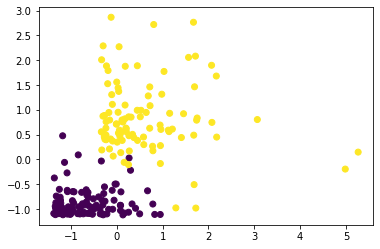

In [46]:
combine = [one,two]
trees = pd.concat(combine)
normal_tree = normalize(trees, 4)
label_df = kmeans_tree(normal_tree, 2)

import matplotlib.pyplot as plot

#get cols
tree_0 = np.array(normal_tree.iloc[:,1])
tree_1 = np.array(normal_tree.iloc[:,3])
label = np.array(label_df)

plot.scatter(tree_0, tree_1, c = label)

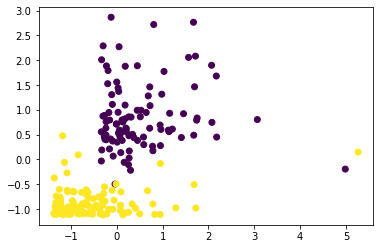

In [19]:
actual_label = pd.DataFrame({'label': [1] * len(one.index) + [2] * len(two.index)})
tree_0 = np.array(normal_tree.iloc[:,1])
tree_1 = np.array(normal_tree.iloc[:,3])
label = np.array(actual_label)

plot.scatter(tree_0, tree_1, c = label)

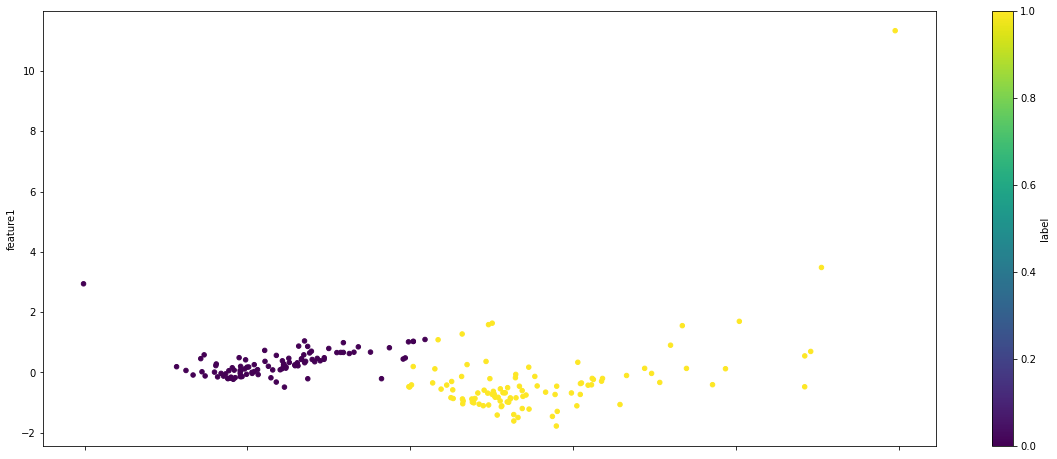

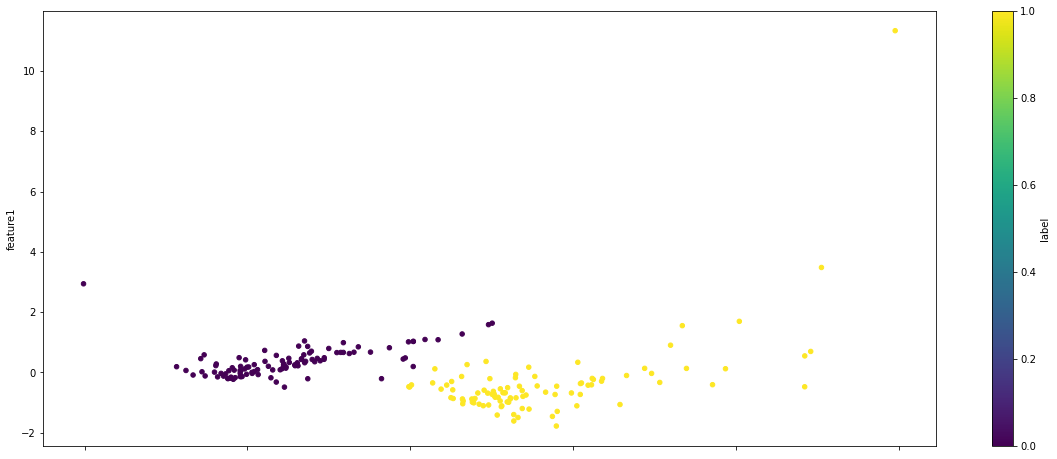

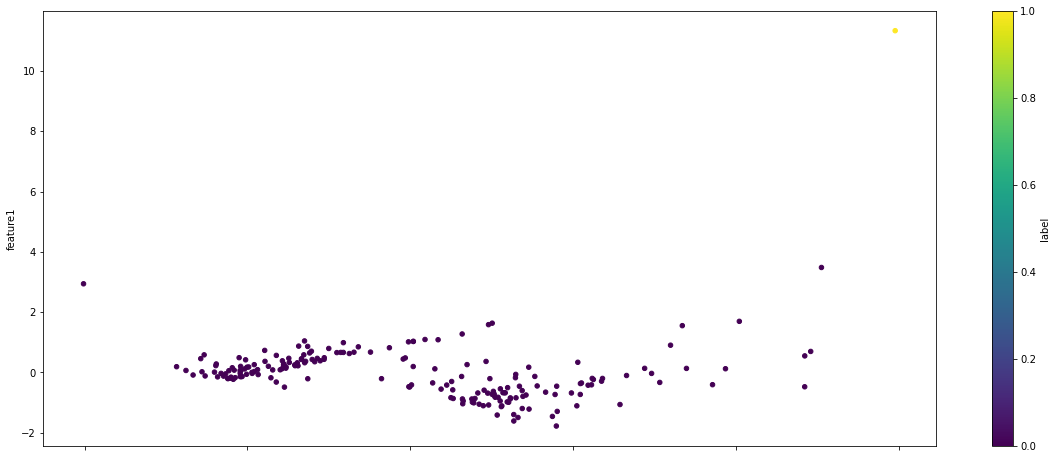

In [47]:
trees = pd.concat([one, two],ignore_index=True,sort=False)
trees = normalize(trees, 4)
plot_kmeans_cluster(trees, 2);
plot_GMM_cluster(trees, 2);
plot_SC_cluster(trees, 2);

<AxesSubplot:xlabel='feature0', ylabel='feature1'>

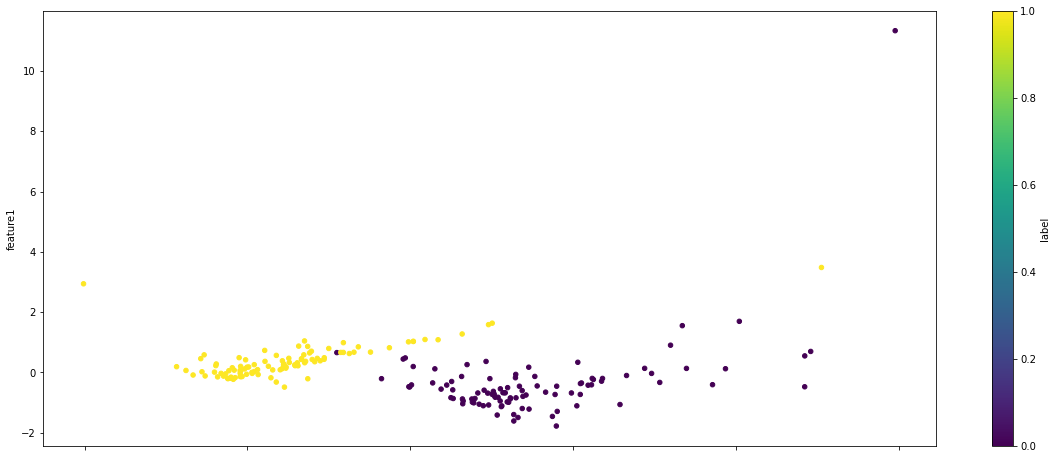

In [48]:
combine = actual_combine(one,two, 4)
combine.plot.scatter(x = "feature0", y = "feature1", c ='label',cmap="viridis",figsize=(20,8))

0.955
0.97
0.505


(None, None, None)

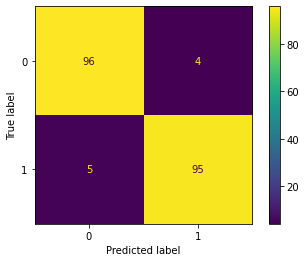

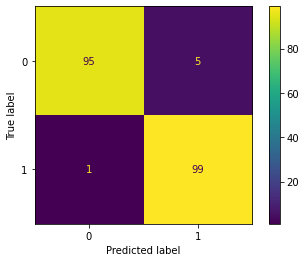

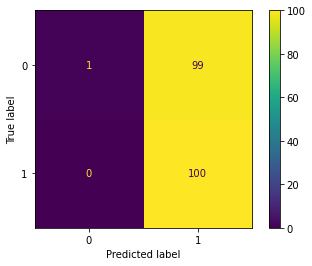

In [49]:
accuracy_labels_2(one, two, 4,"kmeans"), accuracy_labels_2(one, two, 4,"GMM"), accuracy_labels_2(one, two, 4,"SC")

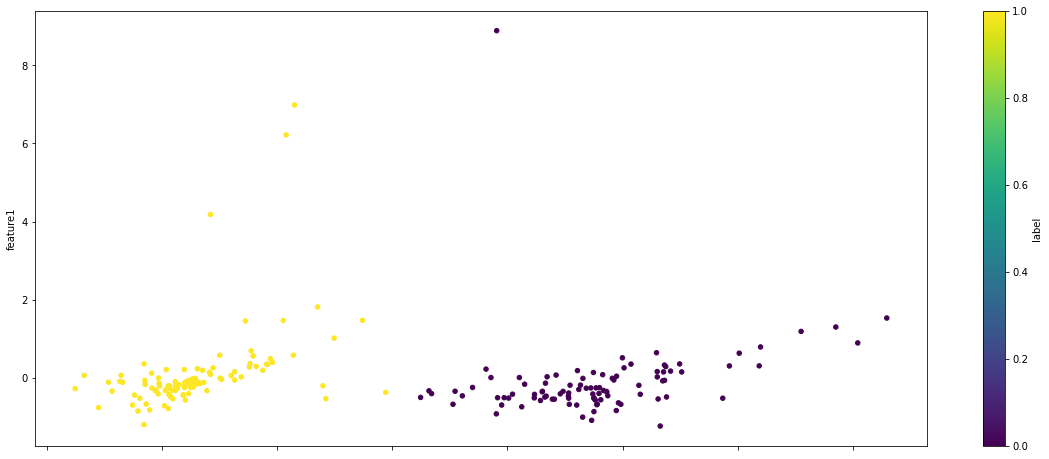

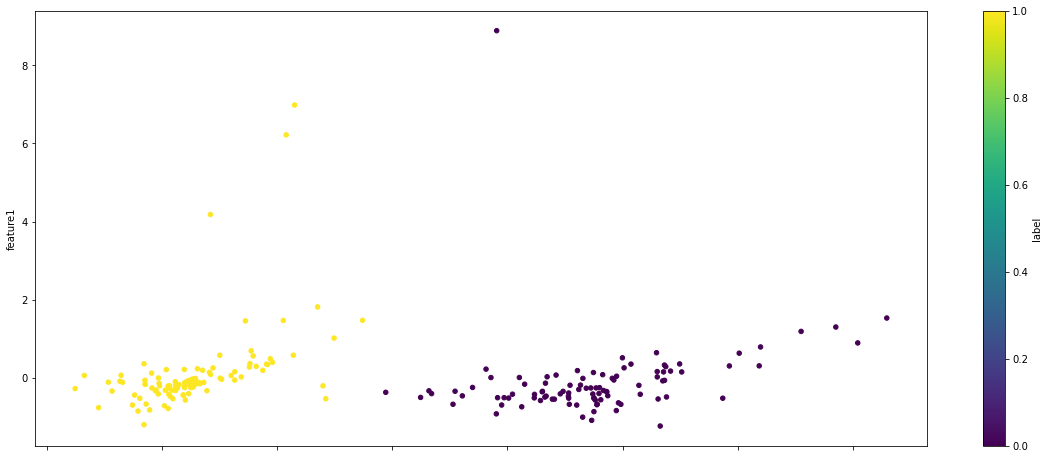

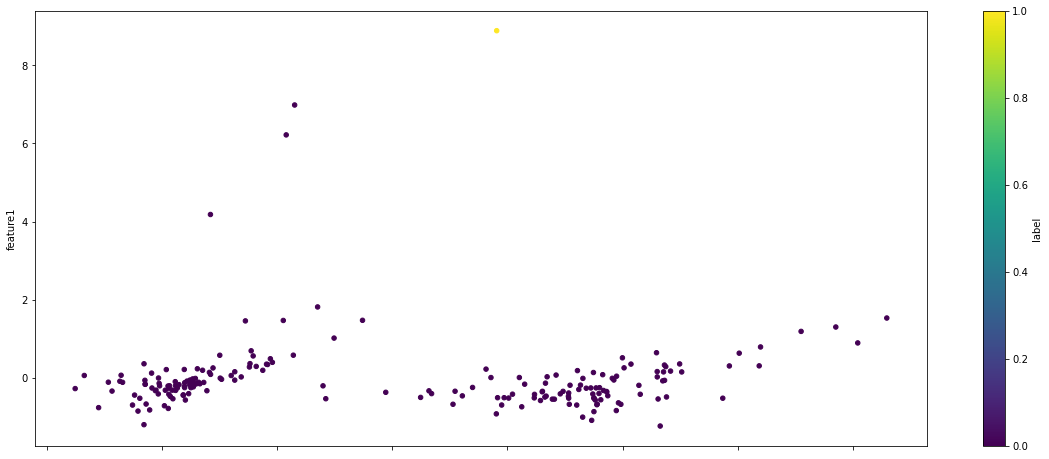

In [50]:
trees = pd.concat([one, three],ignore_index=True,sort=False)
trees = normalize(trees, 4)
plot_kmeans_cluster(trees, 2)
plot_GMM_cluster(trees, 2)
plot_SC_cluster(trees, 2)

<AxesSubplot:xlabel='feature0', ylabel='feature1'>

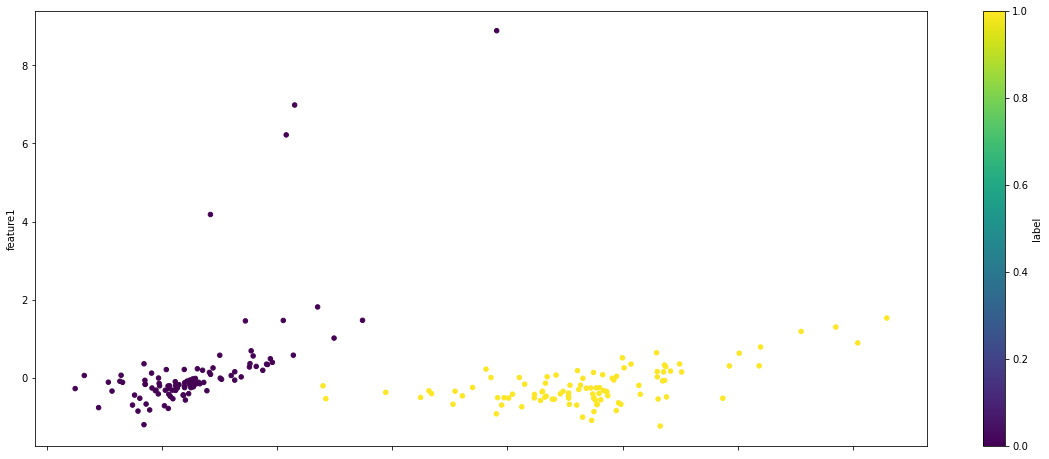

In [51]:
combine = actual_combine(one,three,4)
combine.plot.scatter(x = "feature0", y = "feature1", c ='label',cmap="viridis",figsize=(20,8))

0.98
0.985


(None, None)

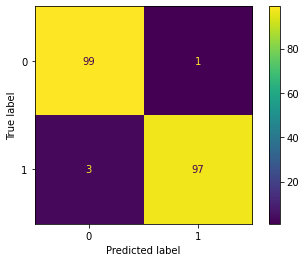

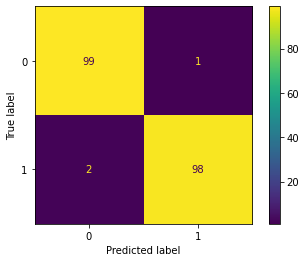

In [52]:
accuracy_labels_2(one, three, 4,"kmeans"), accuracy_labels_2(one, three, 4,"GMM")

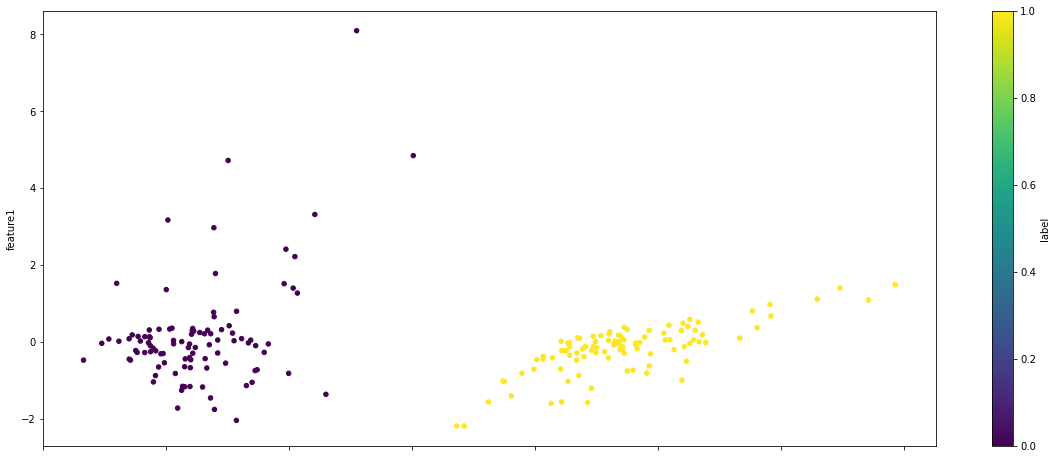

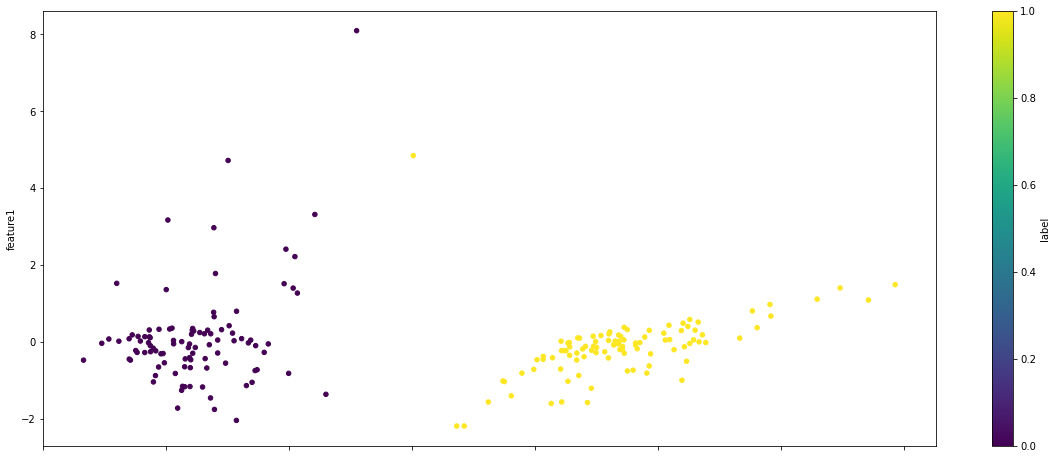

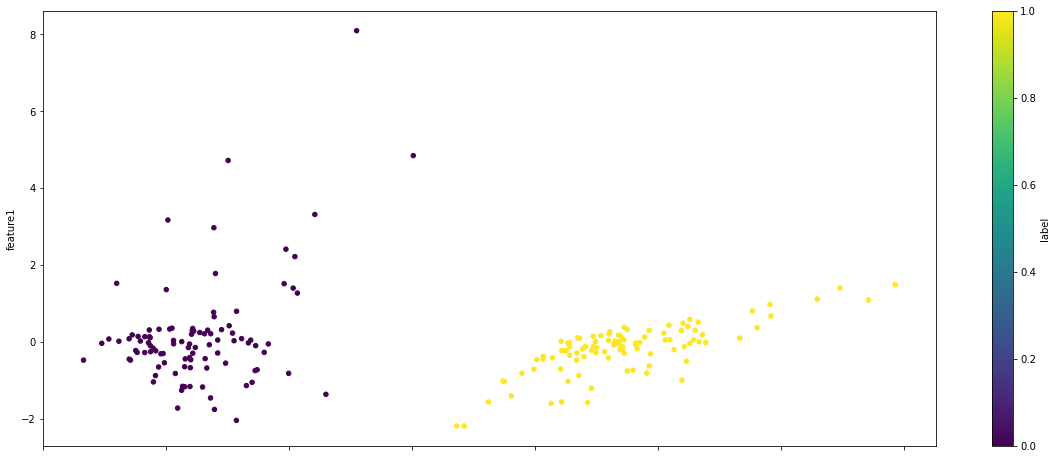

In [53]:
trees = pd.concat([three, four],ignore_index=True,sort=False)
trees = normalize(trees, 4)
plot_kmeans_cluster(trees, 2)
plot_GMM_cluster(trees, 2)
plot_SC_cluster(trees, 2)

<AxesSubplot:xlabel='feature0', ylabel='feature1'>

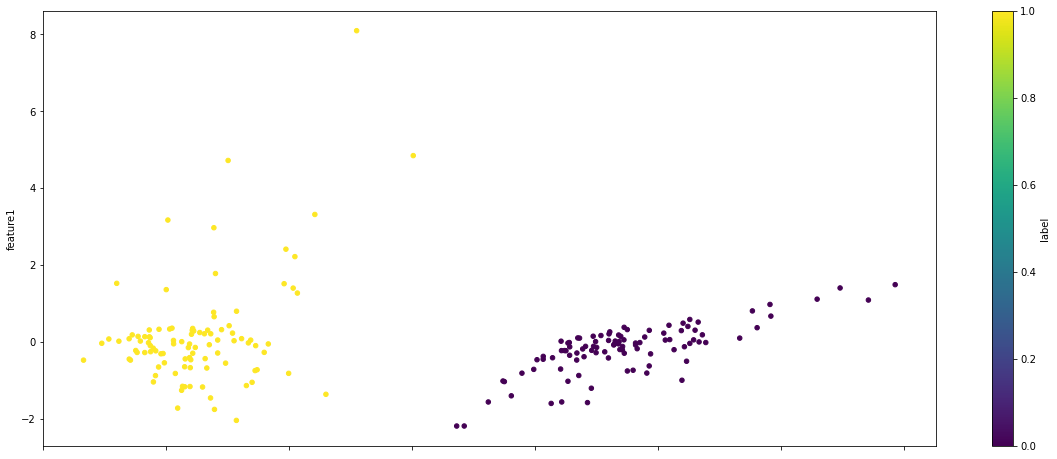

In [54]:
combine = actual_combine(three,four,4)
combine.plot.scatter(x = "feature0", y = "feature1", c ='label',cmap="viridis",figsize=(20,8))

1.0
0.995
1.0


(None, None, None)

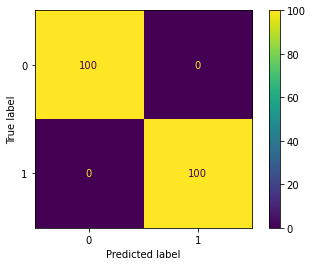

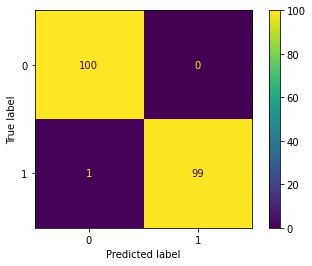

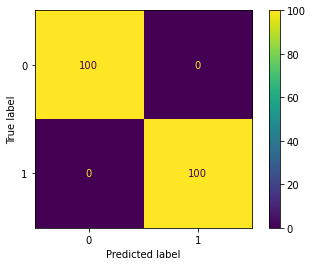

In [55]:
accuracy_labels_2(three,four,4,"kmeans"), accuracy_labels_2(three,four,4,"GMM"), accuracy_labels_2(three,four,4,"SC")

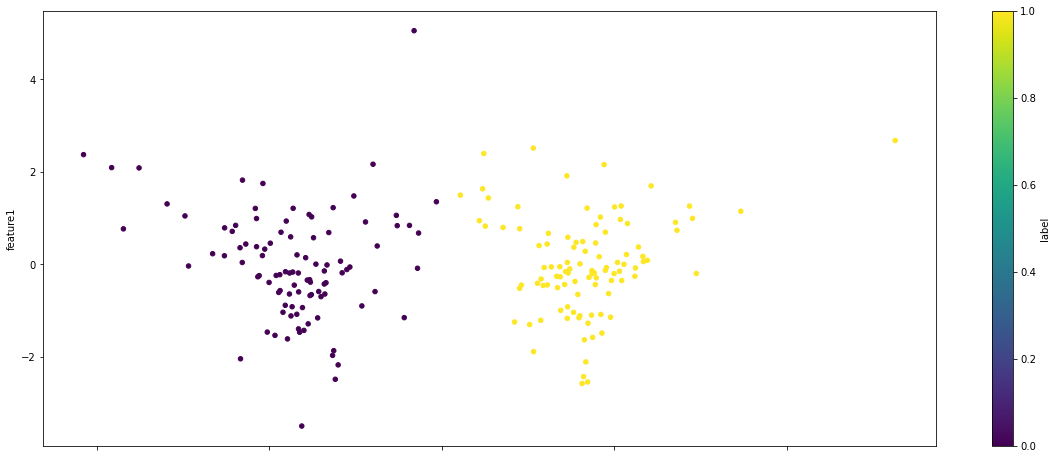

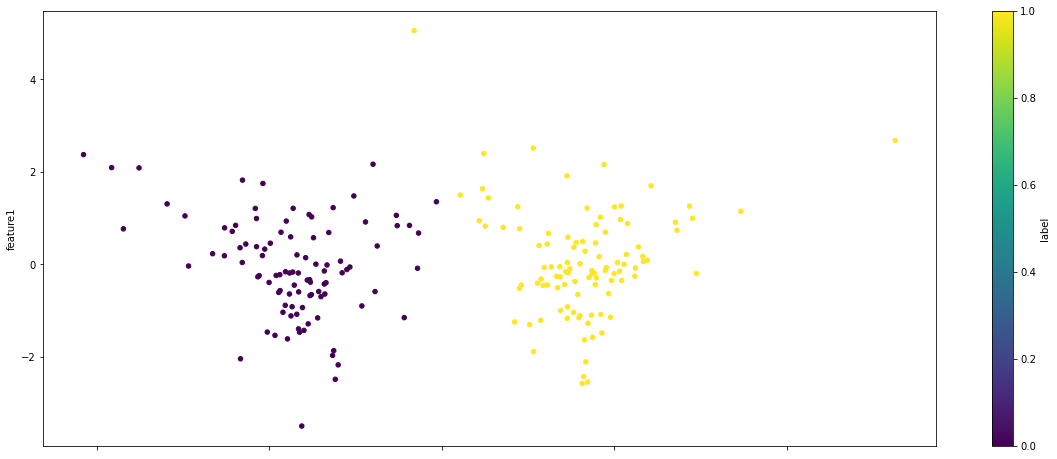

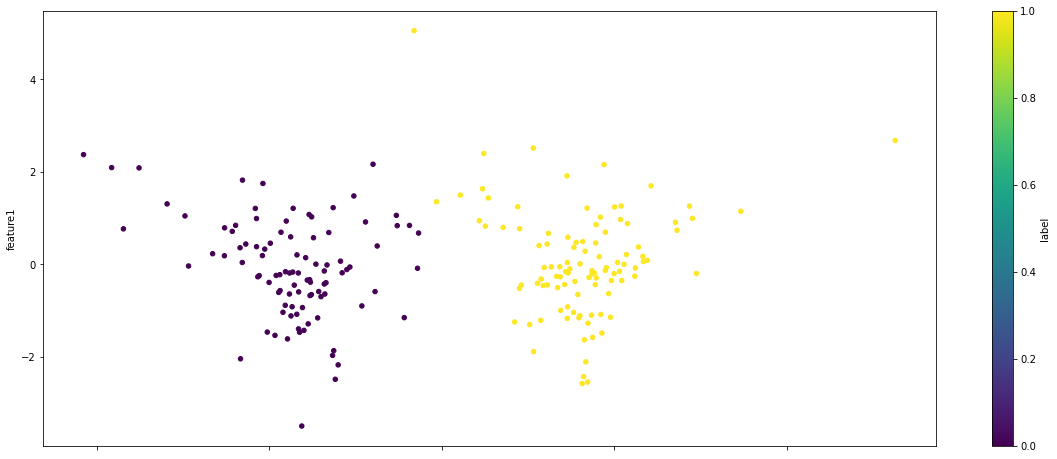

In [56]:
trees = pd.concat([two, three],ignore_index=True,sort=False)
trees = normalize(trees, 4)
plot_kmeans_cluster(trees, 2)
plot_GMM_cluster(trees, 2)
plot_SC_cluster(trees, 2)

<AxesSubplot:xlabel='feature0', ylabel='feature1'>

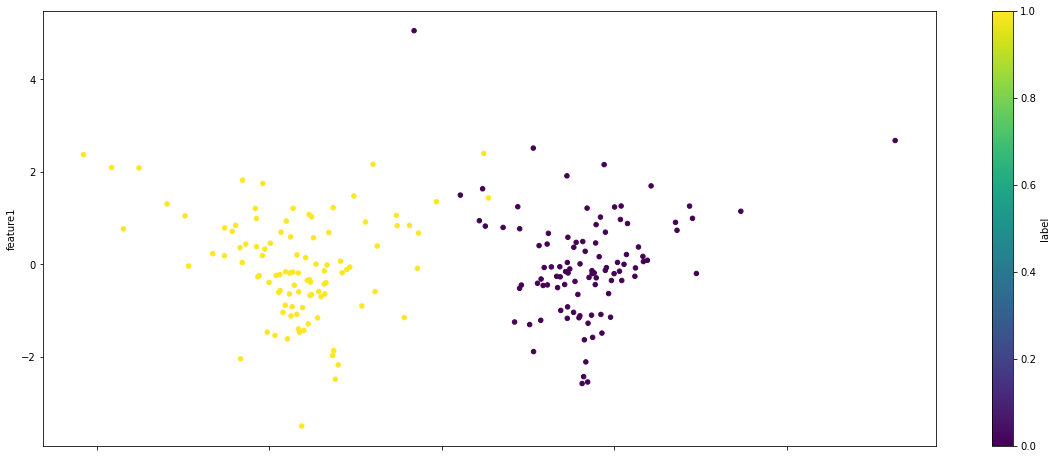

In [57]:
combine = actual_combine(two, three,4)
combine.plot.scatter(x = "feature0", y = "feature1", c ='label',cmap="viridis",figsize=(20,8))

0.985
0.99
0.985


(None, None, None)

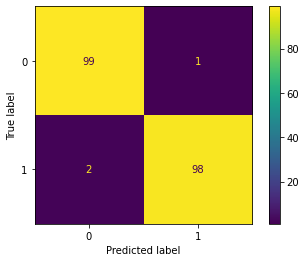

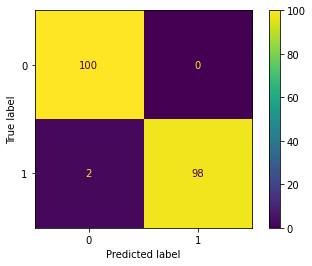

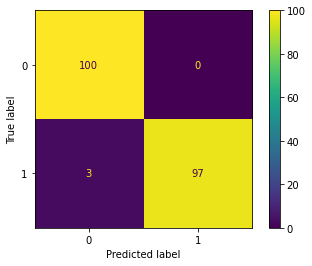

In [58]:
accuracy_labels_2(two, three, 4,"kmeans"), accuracy_labels_2(two, three, 4,"GMM"), accuracy_labels_2(two,three, 4,"SC")

In [59]:
'''
5 taxa trees

'''

# ((4:2.5,5:2.5):1.5,(1:1.6,(2:1.2,3:1.2):0.4):2.4);
one = pd.read_csv("./data/5_one.csv")

# (((2:0.8,1:0.8):2.2,(3:1.7, 5:1.7):1.3):1,4:4);
two = pd.read_csv("./data/5_two.csv")

# ((((1:1.4,2:1.4):0.6,3:2):1.2,4:3.2):0.8,5:4);
three = pd.read_csv("./data/5_three.csv")

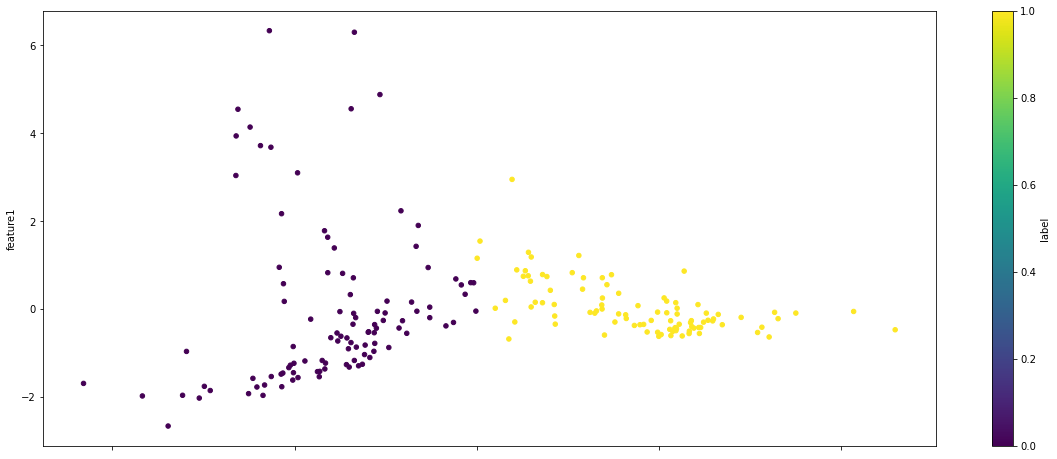

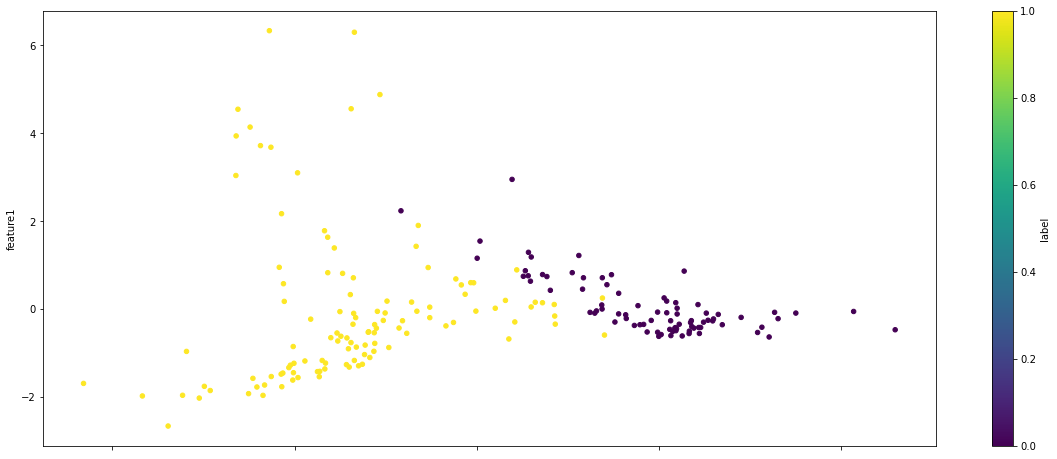

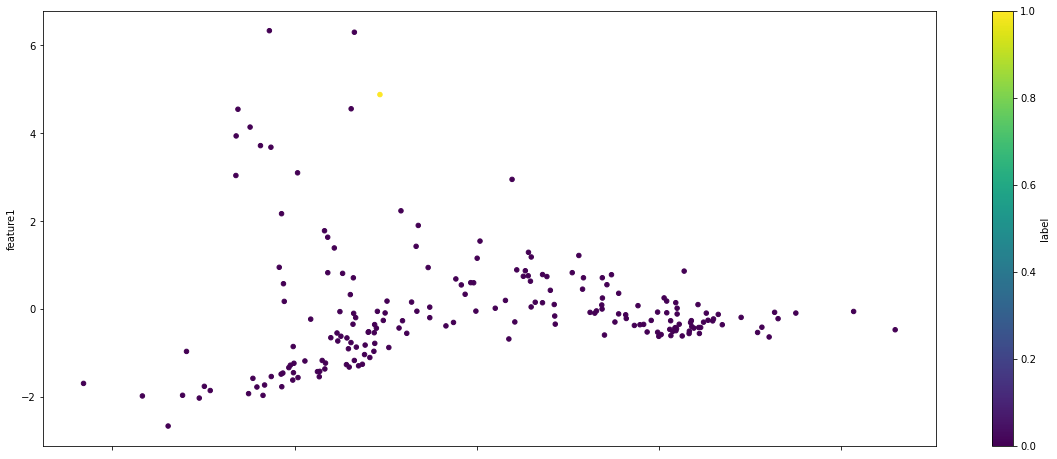

In [60]:
trees = pd.concat([one, two],ignore_index=True,sort=False)
trees = normalize(trees, 5)
plot_kmeans_cluster(trees, 2);
plot_GMM_cluster(trees, 2);
plot_SC_cluster(trees, 2);

<AxesSubplot:xlabel='feature0', ylabel='feature1'>

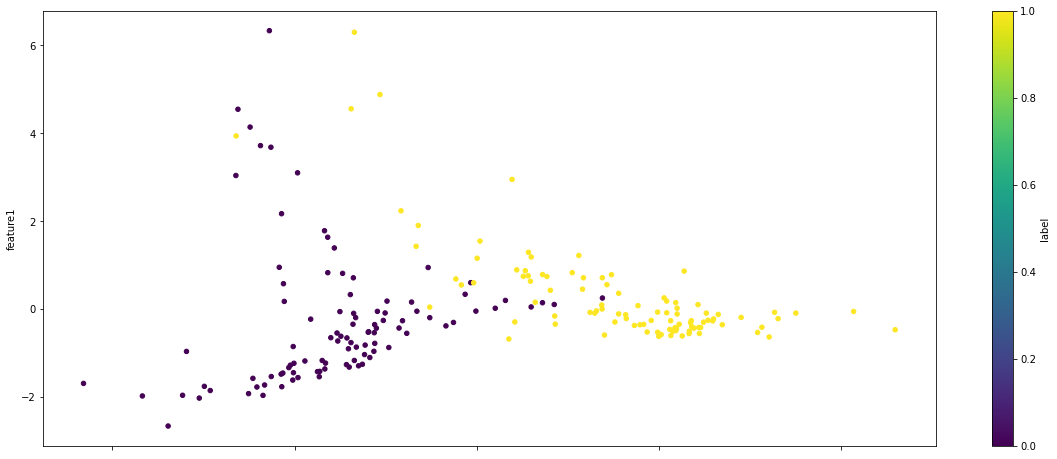

In [61]:
combine = actual_combine(one,two, 5)
combine.plot.scatter(x = "feature0", y = "feature1", c ='label',cmap="viridis",figsize=(20,8))

0.5
0.915
0.5


(None, None, None)

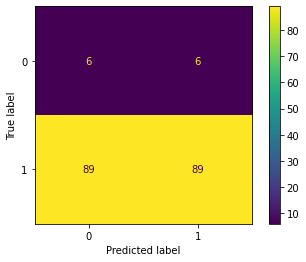

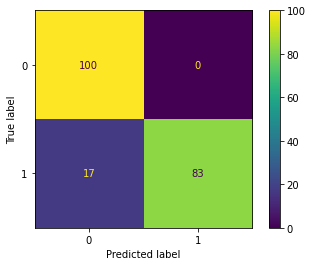

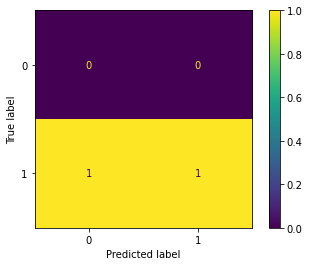

In [62]:
accuracy_labels_2(one,two,5,"kmeans"), accuracy_labels_2(one,two, 5,"GMM"), accuracy_labels_2(one,two,5,"SC")

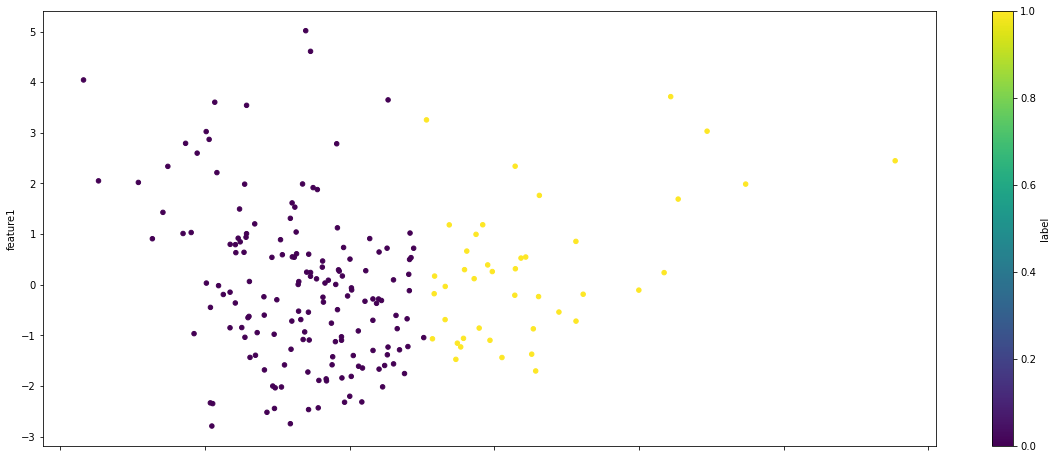

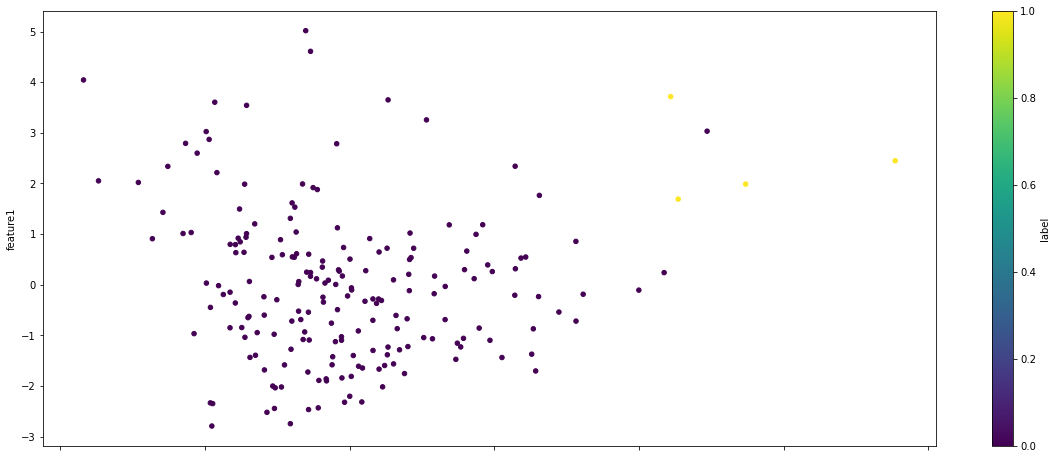

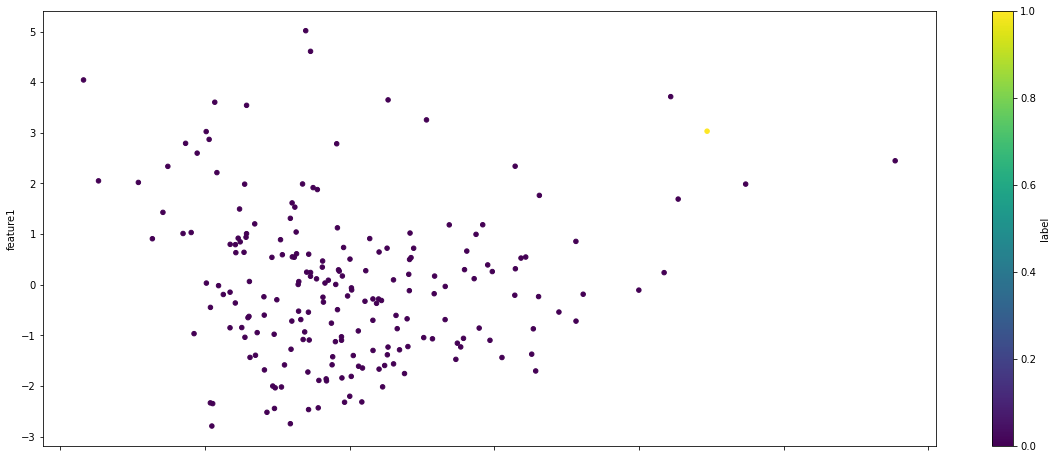

In [64]:
trees = pd.concat([one, three],ignore_index=True,sort=False)
trees = normalize(trees, 5)
plot_kmeans_cluster(trees, 2);
plot_GMM_cluster(trees, 2);
plot_SC_cluster(trees, 2);

<AxesSubplot:xlabel='feature0', ylabel='feature1'>

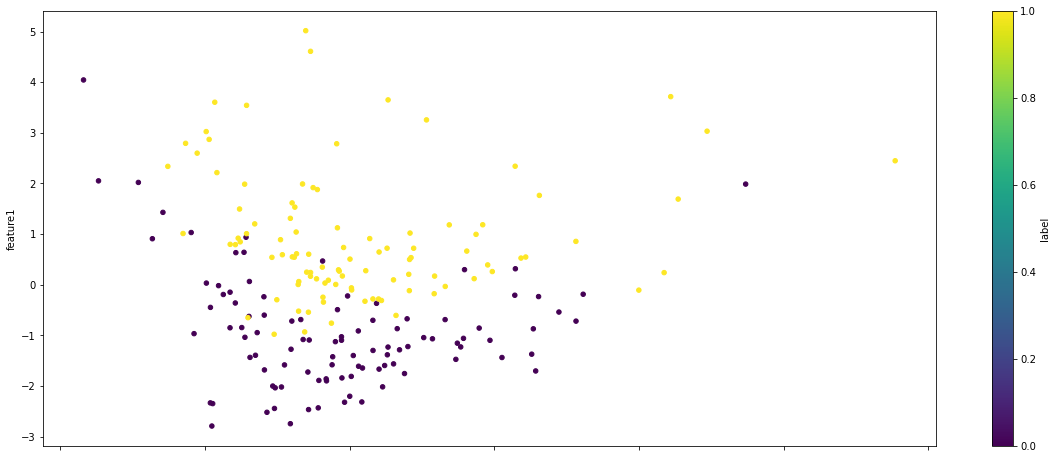

In [65]:
combine = actual_combine(one,three, 5)
combine.plot.scatter(x = "feature0", y = "feature1", c ='label',cmap="viridis",figsize=(20,8))

0.5
0.5
0.5


(None, None, None)

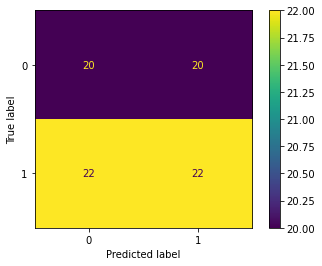

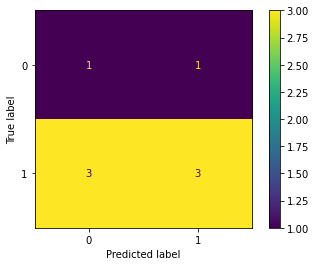

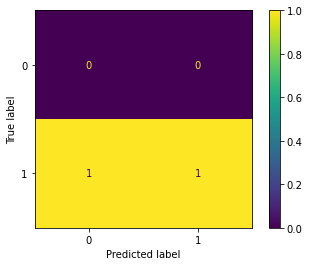

In [66]:
accuracy_labels_2(one,three,5,"kmeans"), accuracy_labels_2(one,three, 5,"GMM"), accuracy_labels_2(one,three,5,"SC")

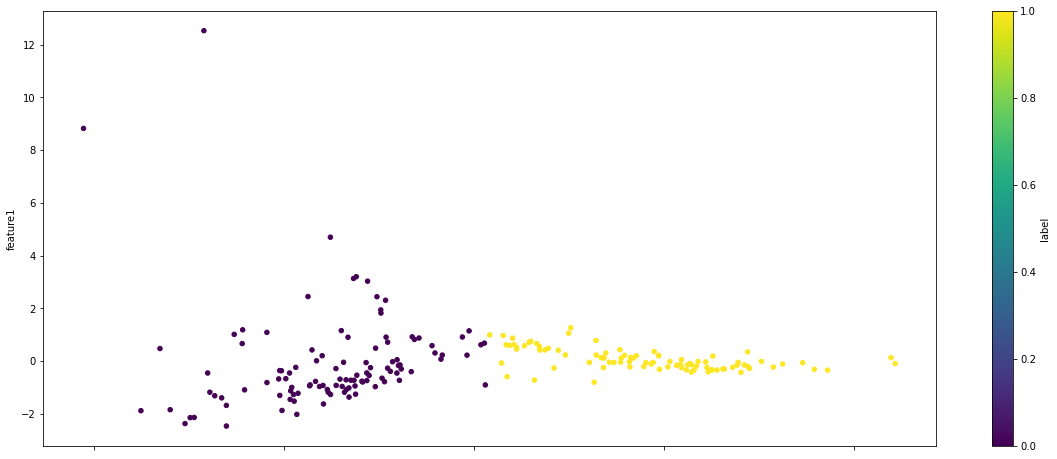

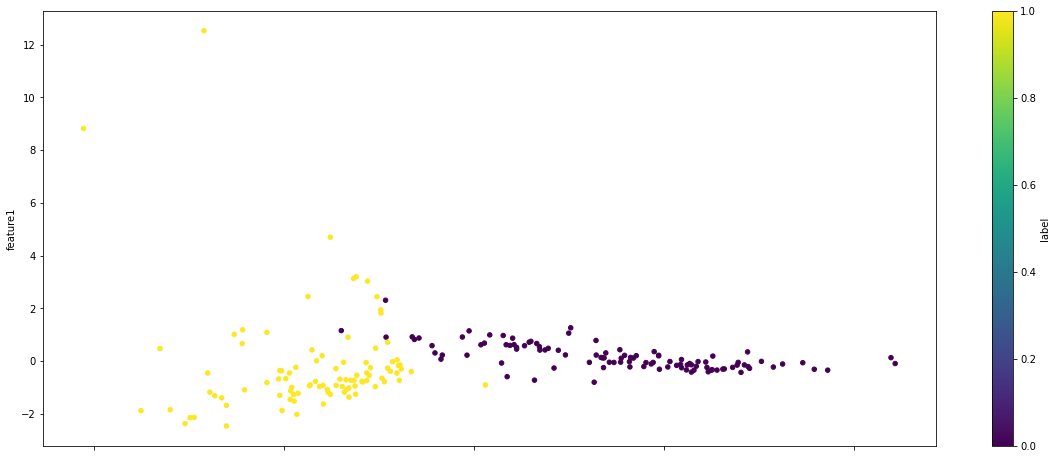

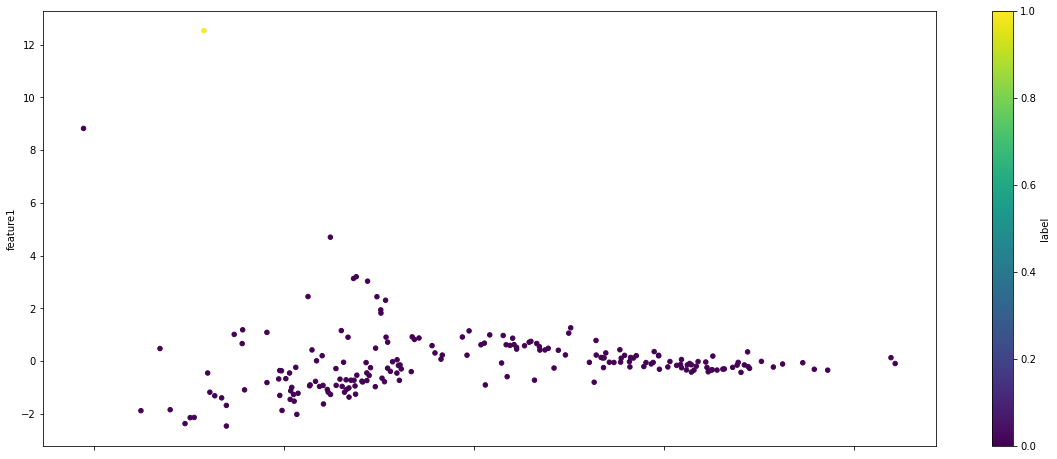

In [67]:
trees = pd.concat([two, three],ignore_index=True,sort=False)
trees = normalize(trees, 5)
plot_kmeans_cluster(trees, 2);
plot_GMM_cluster(trees, 2);
plot_SC_cluster(trees, 2);

<AxesSubplot:xlabel='feature0', ylabel='feature1'>

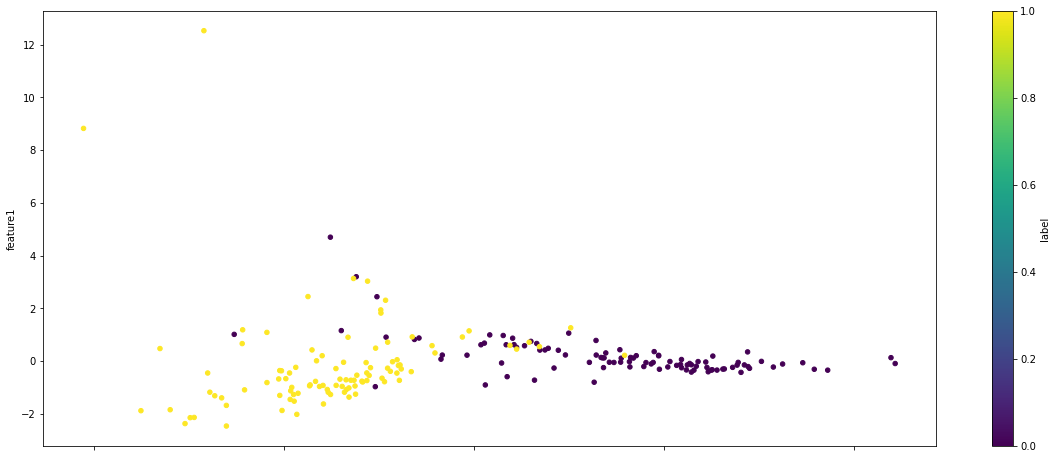

In [68]:
combine = actual_combine(two,three, 5)
combine.plot.scatter(x = "feature0", y = "feature1", c ='label',cmap="viridis",figsize=(20,8))

0.895
0.5
0.5


(None, None, None)

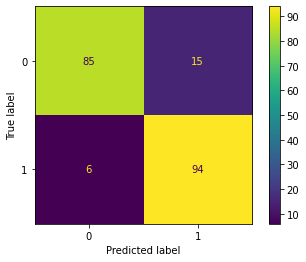

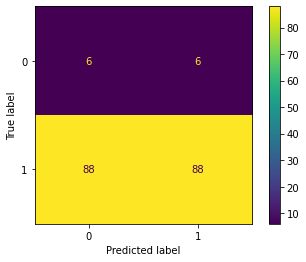

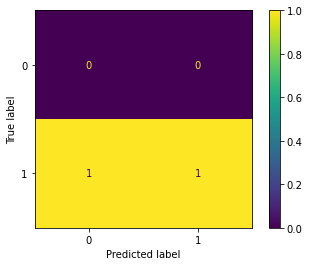

In [69]:
accuracy_labels_2(two,three,5,"kmeans"), accuracy_labels_2(two,three, 5,"GMM"), accuracy_labels_2(two,three,5,"SC")

In [70]:
'''
8 taxa trees

One and two have the similar structure but different branch lengths.

'''

# (8:11.118,((3:4.485,(1:1.976,2:1.976):2.509):1.783,(4:4.911,(5:3.208,(6:1.666,7:1.666):1.541):1.704):1.357):4.850);
one = pd.read_csv("./data/8_one.csv")

# (8:11.087,((4:4.537,(7:3.051,(5:1.855,6:1.855):1.196):1.486):2.953,(1:5.314,(2:2.383,3:2.383):2.931):2.176):3.597);
two = pd.read_csv("./data/8_two.csv")

# (((1:1.8,2:1.8):2.2,(3:0.7,4:0.7):3.3):2,((5:3.7,6:3.7):1.3,(7:2.3,8:2.3):2.7):1);
three = pd.read_csv("./data/8_three.csv")

# (((((1:1.7,2:1.7):0.8,3:2.5):1.3,4:3.8):3.2,(((5:0.6,6:0.6):2.9,7:3.5):1.3,8:4.8):2.2));
four = pd.read_csv("./data/8_four.csv")

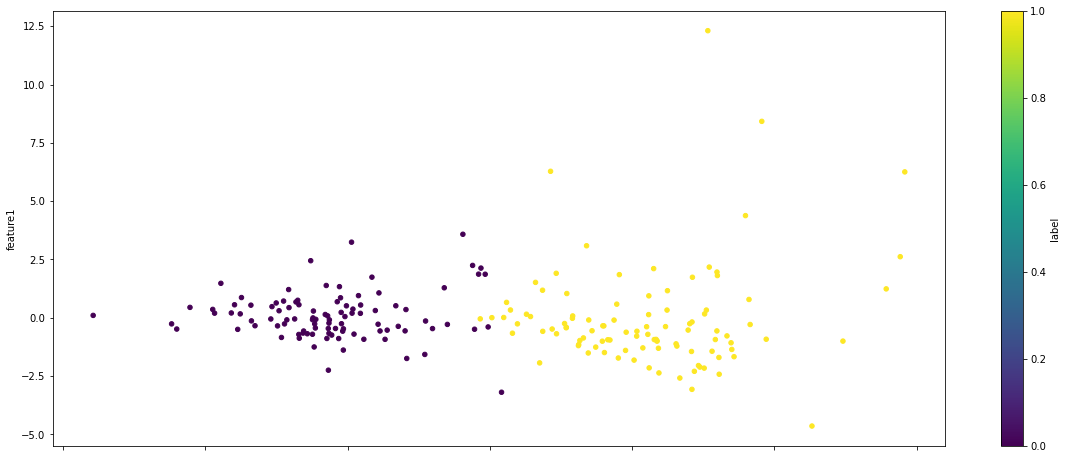

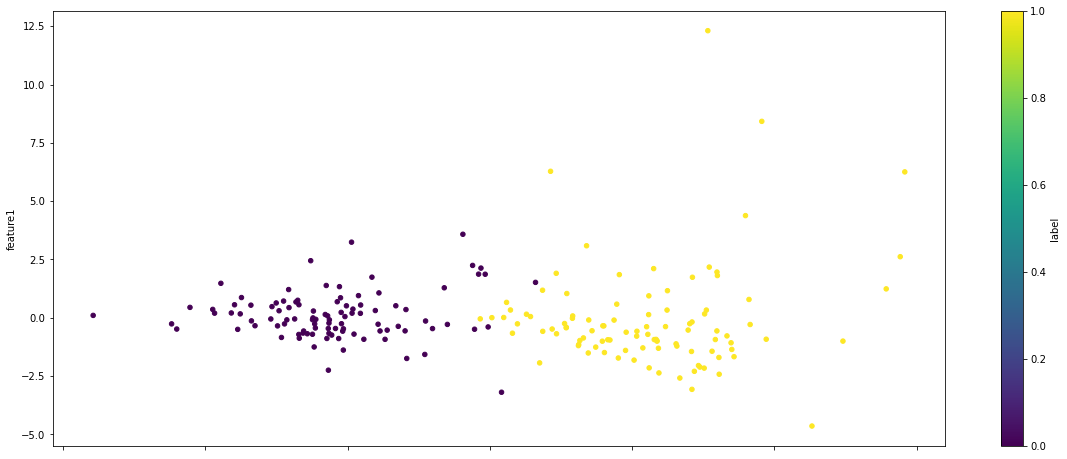

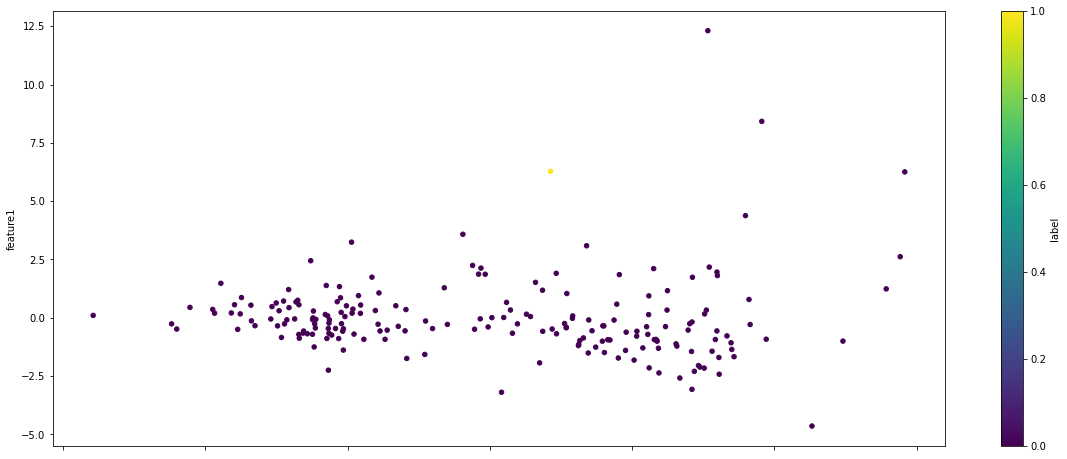

In [71]:
trees = pd.concat([one, two],ignore_index=True,sort=False)
trees = normalize(trees, 8)
plot_kmeans_cluster(trees, 2);
plot_GMM_cluster(trees, 2);
plot_SC_cluster(trees, 2);

<AxesSubplot:xlabel='feature0', ylabel='feature1'>

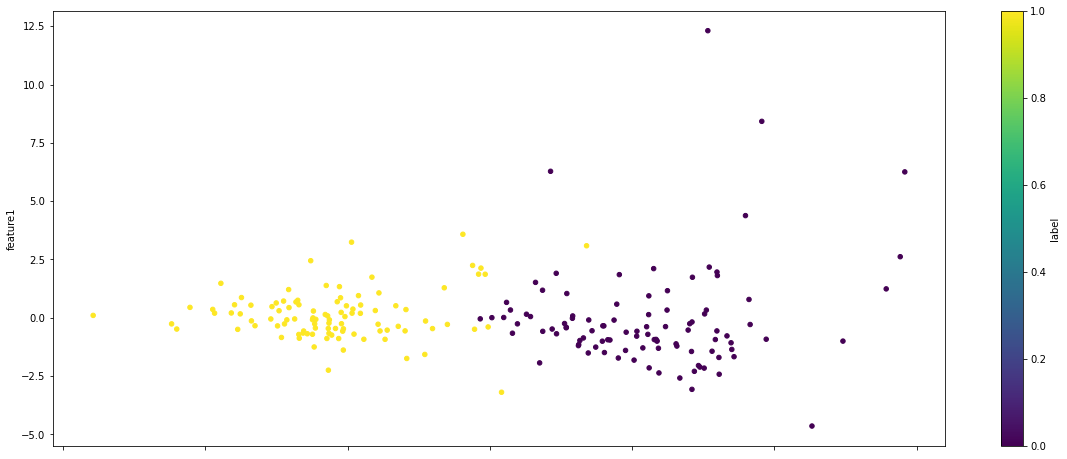

In [72]:
combine = actual_combine(one,two, 8)
combine.plot.scatter(x = "feature0", y = "feature1", c ='label',cmap="viridis",figsize=(20,8))

0.995
0.99
0.505


(None, None, None)

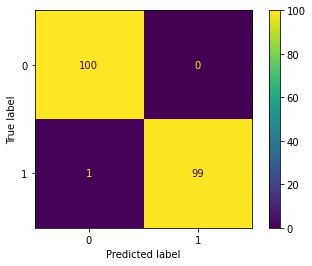

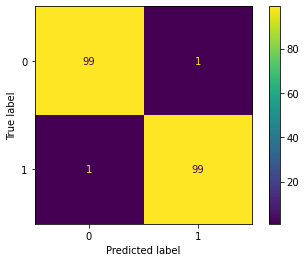

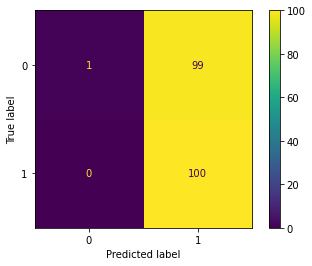

In [73]:
accuracy_labels_2(one,two,8,"kmeans"), accuracy_labels_2(one,two, 8,"GMM"), accuracy_labels_2(one,two,8,"SC")

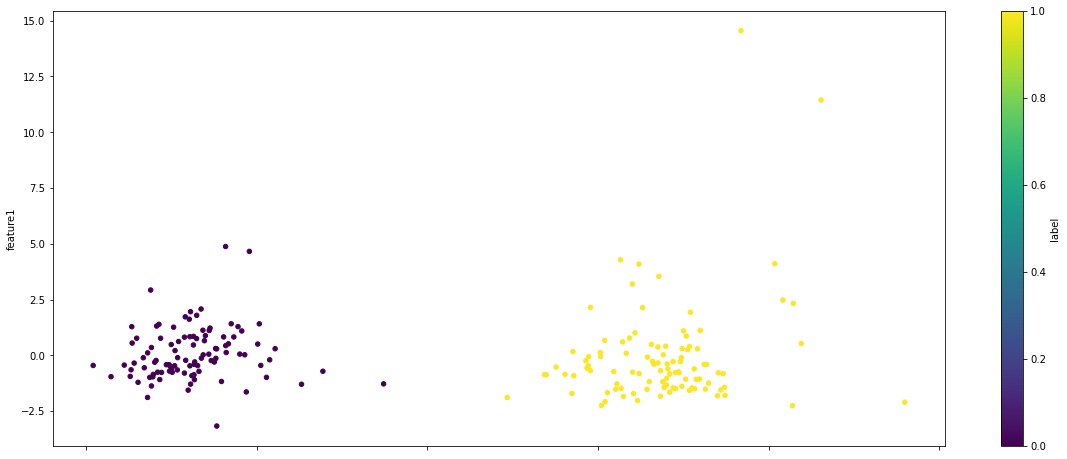

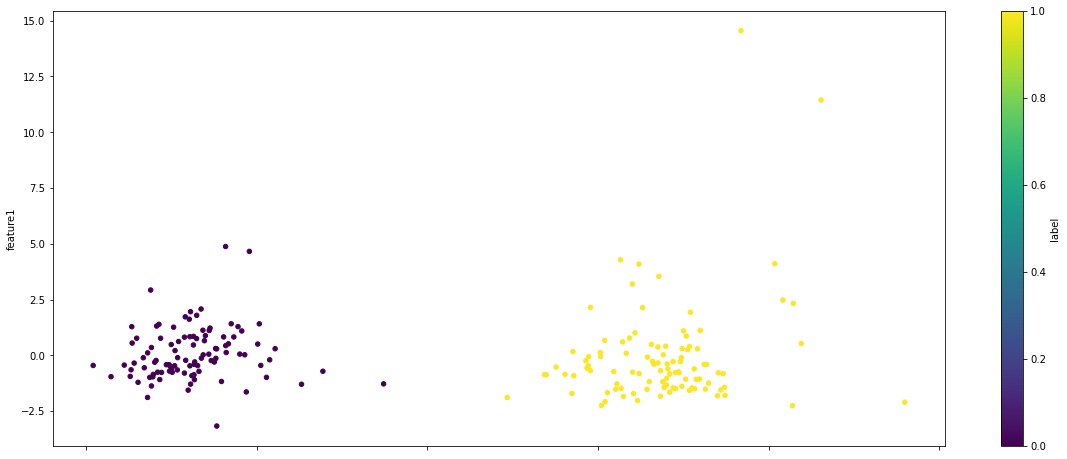

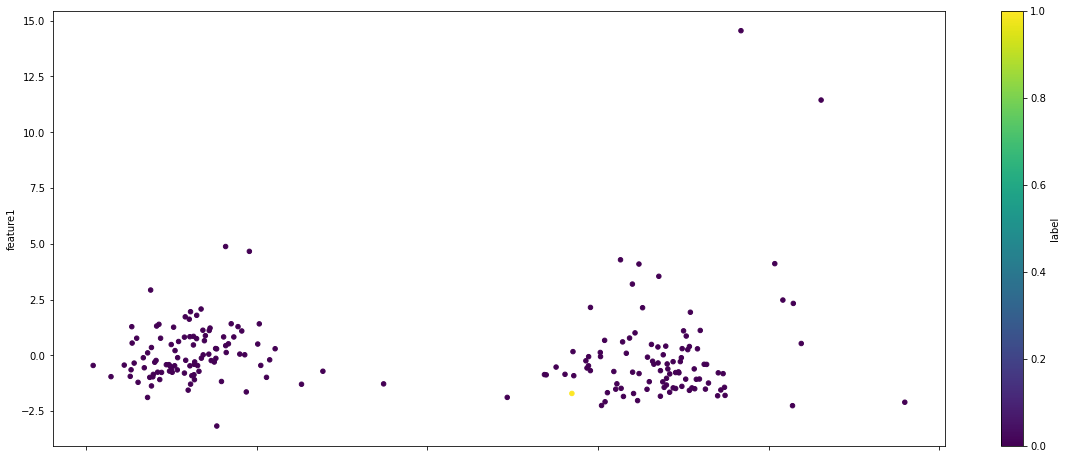

In [74]:
trees = pd.concat([one, three],ignore_index=True,sort=False)
trees = normalize(trees, 8)
plot_kmeans_cluster(trees, 2);
plot_GMM_cluster(trees, 2);
plot_SC_cluster(trees, 2);

<AxesSubplot:xlabel='feature0', ylabel='feature1'>

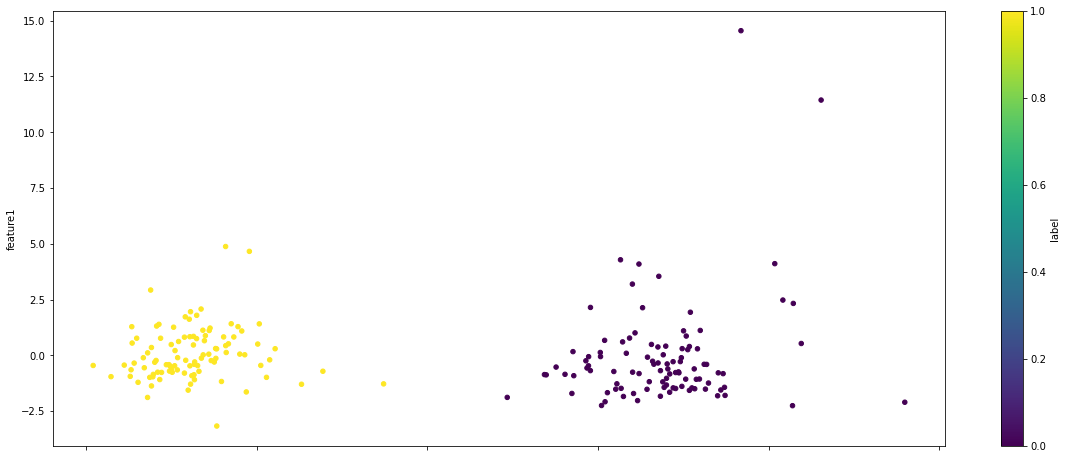

In [75]:
combine = actual_combine(one, three, 8)
combine.plot.scatter(x = "feature0", y = "feature1", c ='label',cmap="viridis",figsize=(20,8))

1.0
1.0
0.505


(None, None, None)

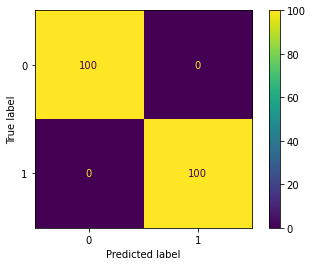

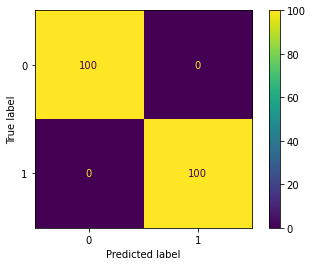

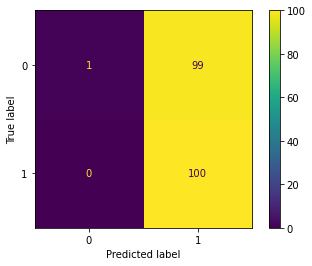

In [76]:
accuracy_labels_2(one, three,8,"kmeans"), accuracy_labels_2(one, three, 8,"GMM"), accuracy_labels_2(one, three,8,"SC")

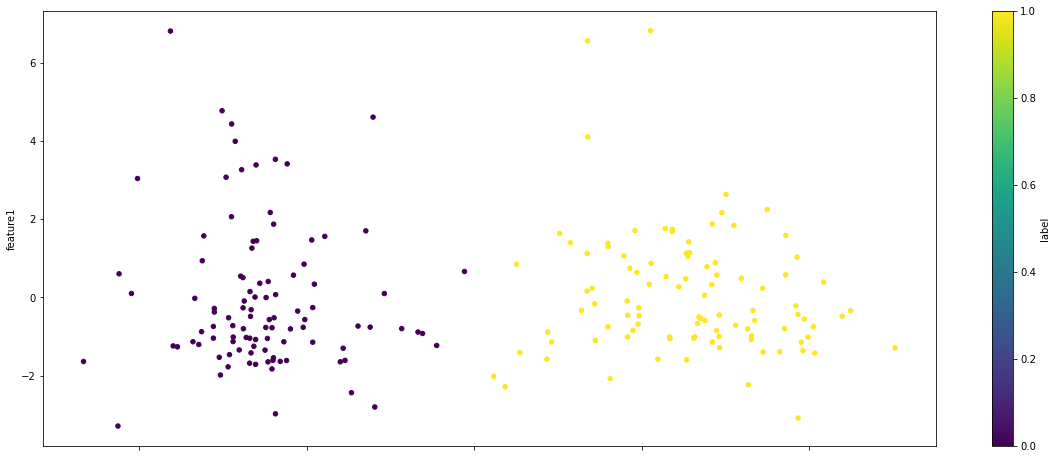

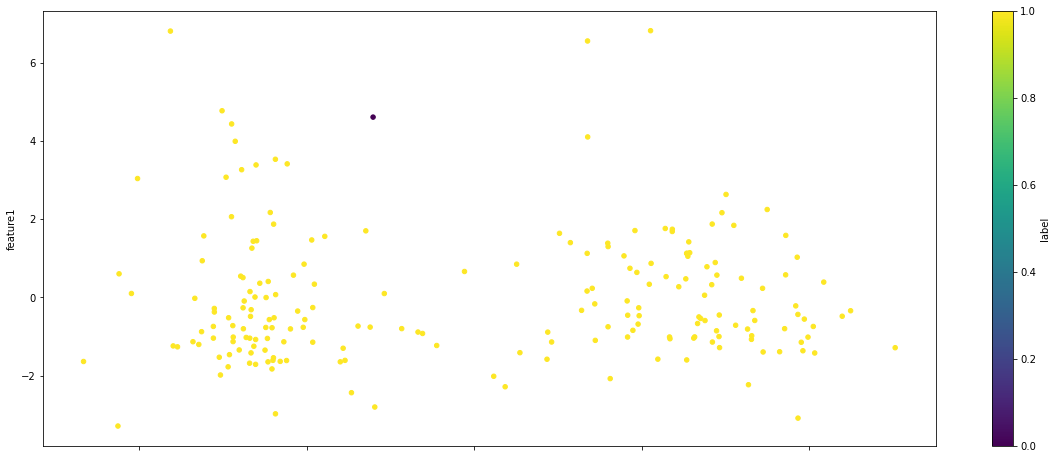

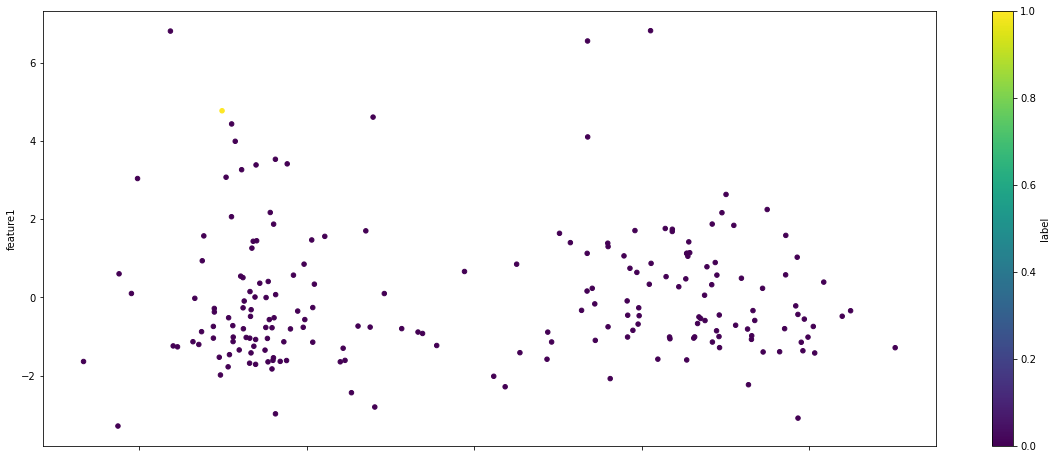

In [77]:
trees = pd.concat([three, four],ignore_index=True,sort=False)
trees = normalize(trees, 8)
plot_kmeans_cluster(trees, 2);
plot_GMM_cluster(trees, 2);
plot_SC_cluster(trees, 2);

<AxesSubplot:xlabel='feature0', ylabel='feature1'>

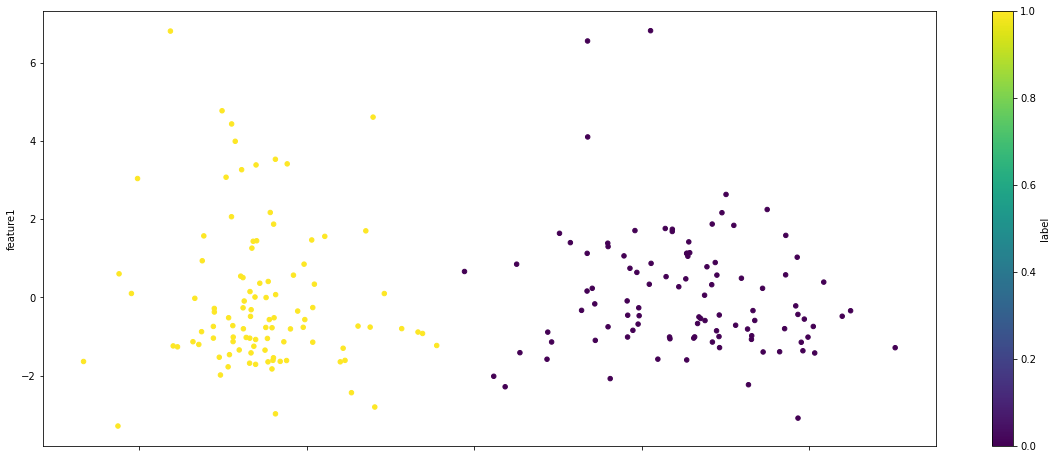

In [78]:
combine = actual_combine(three, four, 8)
combine.plot.scatter(x = "feature0", y = "feature1", c ='label',cmap="viridis",figsize=(20,8))

0.995
0.505
0.5


(None, None, None)

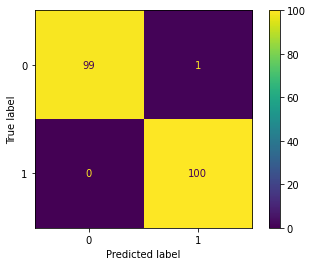

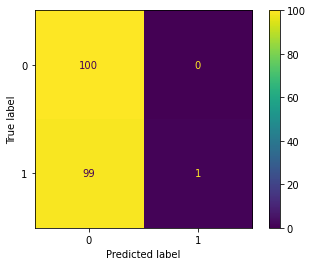

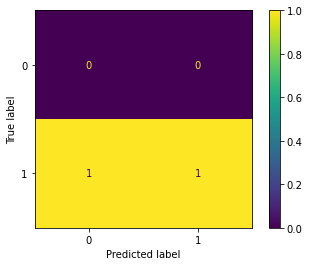

In [79]:
accuracy_labels_2(three, four,8,"kmeans"), accuracy_labels_2(three, four, 8,"GMM"), accuracy_labels_2(three, four,8,"SC")